## Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
from scipy.stats import norm
#from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis#,QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import NMF

import scratch as s
s.SAVE = True # Save figures to disk
from __init__ import correct
warnings.filterwarnings('ignore', '.*Data with input dtype int64 was converted to float64 by StandardScaler*')
warnings.filterwarnings('ignore', '.*Only one sample available. You may want to reshape your data array*')
s.print("Ready to begin.")
import matplotlib
matplotlib.rcParams['figure.figsize'] = (4,3)
#matplotlib.rcParams['figure.dpi'] = 600

Ready to begin.


In [2]:
joe = pd.read_excel('bbdp/data/ST_29Mar2016.xlsx')
joe.index = joe['donor_id']
print("%d UPSIT tests with %d features" % joe.shape)

# Remove any UPSIT tests before the last one for each subject (so that each subject only appears once)
styear_maxes = joe.groupby(['donor_id']).styear.transform(max)
joe = joe[joe.styear == styear_maxes]
print("%d most-recent UPSIT tests with %d features" % joe.shape)

for q in range(1,41):
    joe['smell_%d' % q].fillna(0,inplace=True)
joe['upsit_sum'] = sum(joe['smell_%d' % q] for q in range(1,41))
joe = joe[joe['upsit_sum']>0] # Drop subjects who don't have individual responses recorded
print("%d most-recent UPSIT tests containing itemized responses with %d features" % joe.shape)

clinpath = pd.read_excel('bbdp/data/Clinicopathological Correlations.xls')
clinpath.index = clinpath['Donor ID']
df = joe.join(clinpath,how='inner')
print(("%d most-recent UPSIT tests containing itemized responses and pathological diagnoses, "
       "with %d features") % df.shape)

df[df['Last MMSE Test Score']<999.0] # Drop subjects with no MMSE test score recorded
df['dementia'] = (df['Clinpath AD']==1) | (df['Clinpath DLB']==1) | (df['Clinpath FTLD-TDP43']==1) | \
                       (df['Clinpath VaD']==1) | (df['Dementia Nos']==1) # Set a binary dementia feature.  
print(("%d most-recent UPSIT tests containing itemized responses, MMSE scores, "
       "and pathological diagnoses, with %d features") % df.shape)

615 UPSIT tests with 48 features
422 most-recent UPSIT tests with 48 features
282 most-recent UPSIT tests containing itemized responses with 49 features
198 most-recent UPSIT tests containing itemized responses and pathological diagnoses, with 146 features
198 most-recent UPSIT tests containing itemized responses, MMSE scores, and pathological diagnoses, with 147 features


In [3]:
# Add gender and smell features including all the UPSIT question responses.  
keep = ['Last MMSE Test Score',]
clin = df.loc[:,keep+['smell_%d' % q for q in range(1,41)]]
clin['Gender'] = df['Gender']-1
#clin['smoked_in_last_30_days'] = clin['smoked_in_last_30_days'].fillna(0)
clin['smell_reduced'] = df['smell_reduced_or_absent'].fillna(0)==1 # Impute NaN with 0 for qualitative smell assessment.  
clin['smell_absent'] = df['smell_reduced_or_absent'].fillna(0)==2 # Impute NaN with 0 for qualitative smell assessment.   
df['Expired Age'] = np.where(df['Expired Age'] == 900, 95, df['Expired Age'])
mean_mmse = df[df['Last MMSE Test Score']<999]['Last MMSE Test Score'].mean()
clin['Last MMSE Test Score'] = np.where(clin['Last MMSE Test Score'] > 100, mean_mmse, clin['Last MMSE Test Score'])
clin['age'] = (df['Expired Age'] - (df['deathyear'] - df['styear']))
#for age in np.arange(65,95,5):
#    clin['age > %d' % age] = (df['Expired Age'] - (df['deathyear'] - df['styear'])) >= age # Determine the age at test time.
    
# Replace the actual UPSIT responses ('a', 'b', etc.) with indicator variables (1 or 0)
# reflecting whether they selected 'a', 'b', etc.  
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        clin['upsit_%d%s' % (q,letter)] = clin['smell_%d' % q]==(i+1)
    clin['upsit_%d_responded' % (q)] = clin['smell_%d' % q]>0
    clin['upsit_%d_correct' % (q)] = clin['smell_%d' % q]==correct[q-1]
    clin.drop('smell_%d' % q,axis=1,inplace=True)
for i,letter in enumerate(['a','b','c','d']):
    clin['upsit_order_%s' % letter] = sum([clin['upsit_%d%s' % (q,letter)] for q in range(1,41)])
clin['upsit_total_responded'] = sum([clin['upsit_%d_responded' % q] for q in range(1,41)])
clin['upsit_total_correct'] = sum([clin['upsit_%d_correct' % q] for q in range(1,41)])
#for i in np.arange(0,40,5):
#    clin['upsit_total_correct > %d' % i] = clin['upsit_total_correct']>i    
clin = clin*1
n_nmf = 0
if n_nmf:
    pattern_features = [feature for feature in clin if re.match('upsit_[0-9]+',feature)]
    nmf = NMF(n_components=n_nmf)
    nmf_pattern_features = pd.DataFrame(nmf.fit_transform(clin[pattern_features]),
                                        index=clin.index,
                                        columns=['upsit_%d_nmf' % i for i in range(n_nmf)])
    clin = clin.drop(pattern_features,axis=1).join(nmf_pattern_features)

In [4]:
n_control = ((df['Clinpath PD']==0) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0)).sum()
print("%d subjects with neither PD, AD, nor PSP" % n_control)

80 subjects with neither PD, AD, nor PSP


In [5]:
#mnb = MultinomialNB(alpha=1.0,fit_prior=False) # Multinomial Naive Bayes classifier.  
#bnb = BernoulliNB(alpha=1.0,fit_prior=False) # Bernoulli Naive Bayes classifier.  
#gnb = GaussianNB() # Gaussian Naive Bayes classifier.  
#rfc = RandomForestClassifier(max_depth=5,random_state=0) # Multinomial Naive Bayes classifier. 
svm = SVC(probability=True,C=1.0,random_state=0)

lda = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#n_components=10)
#qda = QuadraticDiscriminantAnalysis()
clfs = [lda,svm]#[bnb,gnb,svm,rfc,lda,qda]

#for key in keys:
#    loo = LeaveOneOut(len(Y[key])) # The "leave one out" cross-validation split.  
#    for use in uses:
#        s.cross_validate(mnb,X[key][use],Y[key],loo,"'%s: %s'" % (key,use)) # Run cross-validation with MNB classifier on TC.  

In [6]:
def make_x(clin,df):
    x = {}
    x['pd'] = clin[df['Clinpath PD']==1]
    x['no_pd'] = clin[df['Clinpath PD']==0]
    x['pd_only'] = clin[(df['Clinpath PD']==1) & (df['dementia']==0)]#df['Clinpath AD']==0) & (df['Clinpath DLB']==0) & \
                 #(df['Clinpath FTLD-TDP43']==0) & (df['Clinpath VaD']==0) & (df['Dementia Nos']==0)]
    x['ctrl'] = clin[(df['Clinpath Control']==1) & (df['Clinpath PSP']==0)]
    x['psp no_pd'] = clin[(df['Clinpath PSP']==1) & (df['Clinpath PD']==0) & (df['dementia']==0)]
    x['pd no_psp'] = clin[(df['Clinpath PSP']==0) & (df['Clinpath PD']==1) & (df['dementia']==0)]
    x['ad'] = clin[df['Clinpath AD']==1]
    x['no_ad'] = clin[df['Clinpath AD']==0]
    x['ad_only'] = clin[(df['Clinpath AD']==1) & (df['Clinpath PD']==0) & (df['Clinpath DLB']==0) & \
                 (df['Clinpath FTLD-TDP43']==0) & (df['Clinpath VaD']==0) & (df['Dementia Nos']==0)]
    x['ctrl'] = clin[df['Clinpath Control']==1]
    return x

x = make_x(clin,df)

In [7]:
keys = {'pd vs no_pd':'PD Diagnosis, +comorbidities',
        'pd_only vs ctrl':'PD Diagnosis',
        'ad vs no_ad':'AD Diagnosis, +comorbidities',
        'ad_only vs ctrl':'AD Diagnosis',
        'pd no_psp vs psp no_pd':'PD vs PSP',
        'psp no_pd vs ctrl':'PSP Diagnosis'}
uses = {'Which Responses':['upsit_total','upsit_order_[a-d]'],
        'Which Correct':['upsit_[0-9]+[a-d]','upsit_order_[a-d]'],
        'Which Order':['upsit_[0-9]+[a-d]','upsit_[0-9]+'],
        'Total Score':['upsit_[0-9]+[a-d]','upsit_[0-9]+','upsit_total_responded','upsit_order_[a-d]'],
        'No UPSIT':['upsit'],
        #'No Smell':['smell','upsit']
        }

	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have both positive and negative examples
	Skipping split 96 because: Must have both positive and negative examples
	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have both positive and negative examples
	Skipping split 96 because: Must have both positive and negative examples
	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have bot

/Users/rgerkin/Dropbox/science/upsit/scratch.py:380: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)


	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=nan
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=nan
	Which Order vs Which Correct: p=nan
	Which Responses vs No UPSIT: p=nan
	Which Responses vs Total Score: p=nan
	Which Responses vs Which Correct: p=nan
	Which Responses vs Which Order: p=nan
	Total Score vs No UPSIT: p=0.0031
	Which Correct vs No UPSIT: p=0.0002
	Which Correct vs Total Score: p=0.1059
	Which Order vs No UPSIT: p=0.0149
	Which Order vs Total Score: p=0.1473
	Which Order vs Which Correct: p=0.0463
	Which Responses vs No UPSIT: p=0.0002
	Which Responses vs Total Score: p=0.1129
	Which Responses vs Which Correct: p=0.2329
	Which Responses vs Which Order: p=0.0486
	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=nan
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=nan
	Which Order vs Which Correct: p=nan
	Which Responses vs No UPSIT: p=nan
	Wh

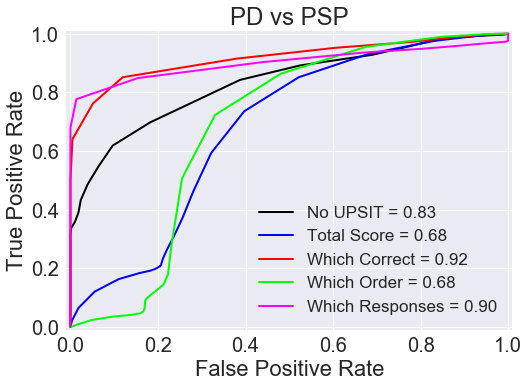

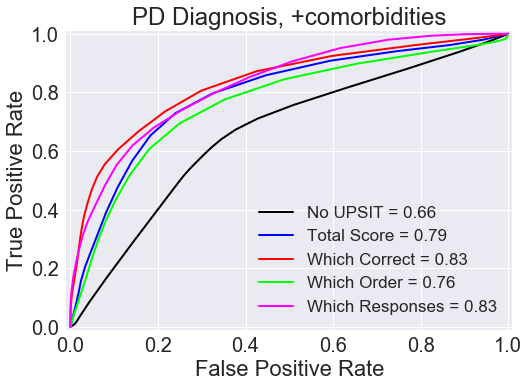

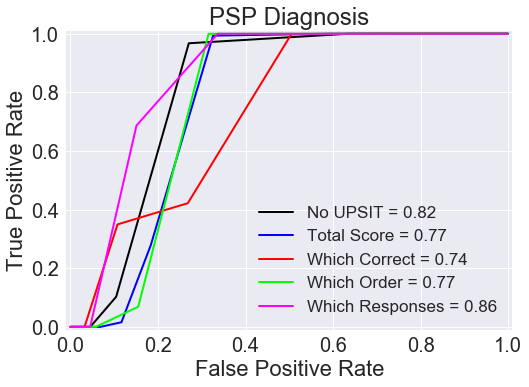

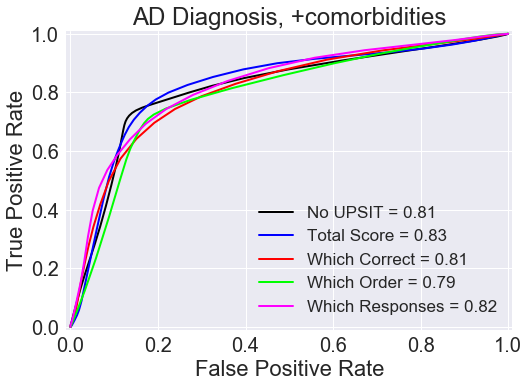

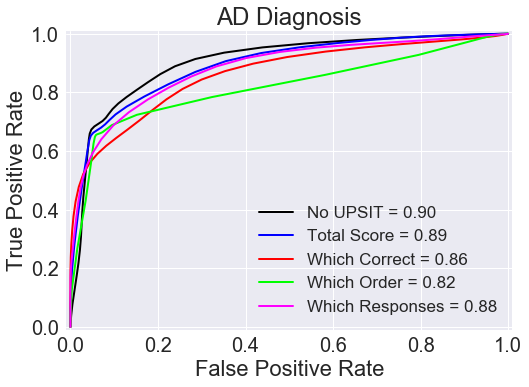

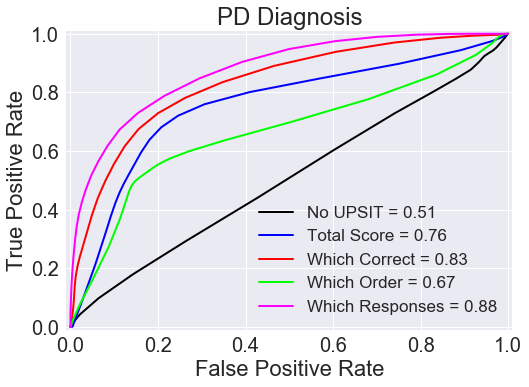

In [8]:
X,Y = s.makeXY(keys,uses,x)
p_pos,ys = s.make_py(keys,uses,X,Y,clfs)
s.plot_rocs(keys,uses,p_pos,Y,ys);

	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have both positive and negative examples
	Skipping split 96 because: Must have both positive and negative examples
	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have both positive and negative examples
	Skipping split 96 because: Must have both positive and negative examples
	Skipping split 4 because: Must have both positive and negative examples
	Skipping split 11 because: Must have both positive and negative examples
	Skipping split 68 because: Must have both positive and negative examples
	Skipping split 92 because: Must have bot

/Users/rgerkin/Dropbox/science/upsit/scratch.py:380: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)


	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=nan
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=nan
	Which Order vs Which Correct: p=nan
	Which Responses vs No UPSIT: p=nan
	Which Responses vs Total Score: p=nan
	Which Responses vs Which Correct: p=nan
	Which Responses vs Which Order: p=nan
	Total Score vs No UPSIT: p=0.0251
	Which Correct vs No UPSIT: p=0.0122
	Which Correct vs Total Score: p=0.1950
	Which Order vs No UPSIT: p=0.0256
	Which Order vs Total Score: p=0.2367
	Which Order vs Which Correct: p=0.1800
	Which Responses vs No UPSIT: p=0.0326
	Which Responses vs Total Score: p=0.2195
	Which Responses vs Which Correct: p=0.1647
	Which Responses vs Which Order: p=0.2319
	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=nan
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=nan
	Which Order vs Which Correct: p=nan
	Which Responses vs No UPSIT: p=nan
	Wh

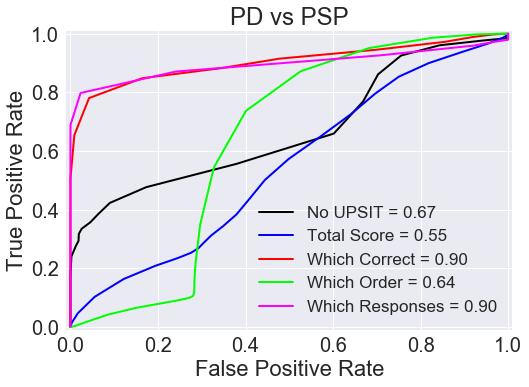

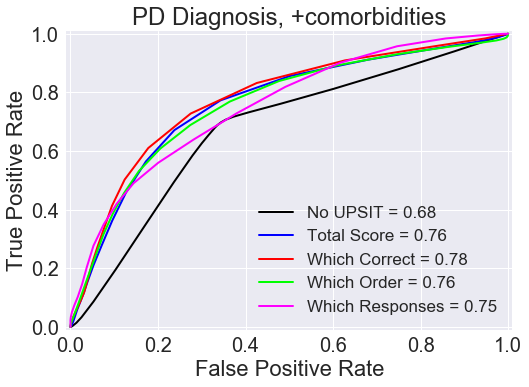

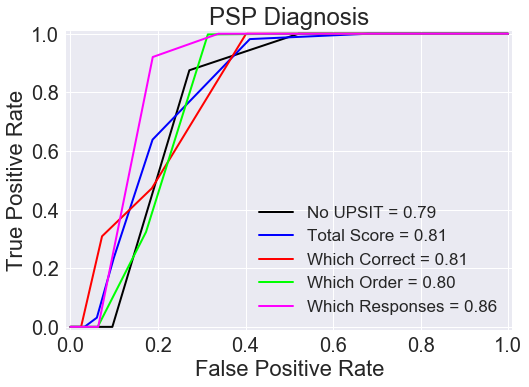

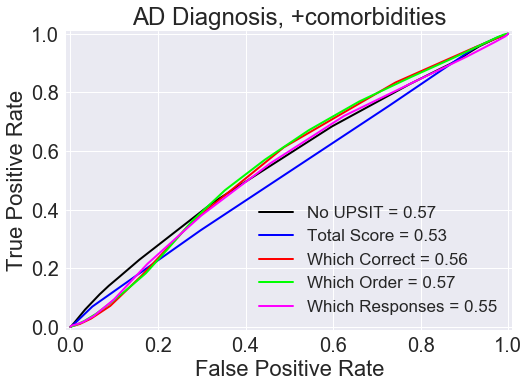

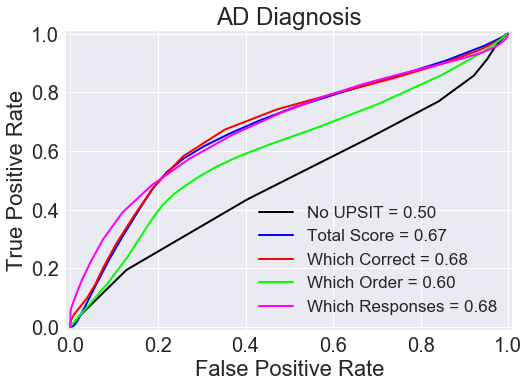

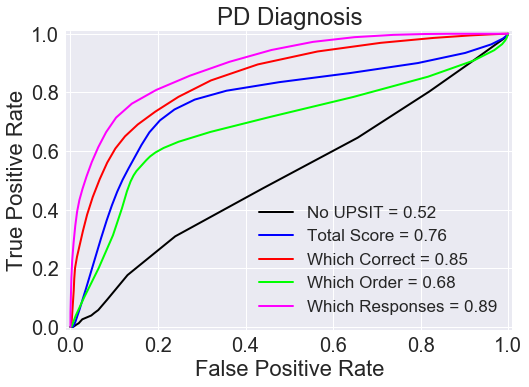

In [9]:
X,Y = s.makeXY(keys,uses,x,drop_more=['Last MMSE Test Score'])
p_pos,ys = s.make_py(keys,uses,X,Y,clfs)
s.plot_rocs(keys,uses,p_pos,Y,ys);

In [10]:
men = list(clin.index[clin['Gender']==1])
women = list(clin.index[clin['Gender']==2])
old = list(clin.index[clin['age']>=80])
young = list(clin.index[clin['age']<80])

In [11]:
#d = np.abs((0.913-0.849)/np.sqrt((0.050**2 + 0.061**2)/2))
#p = (1-norm.cdf(d,0,1))/2
#p

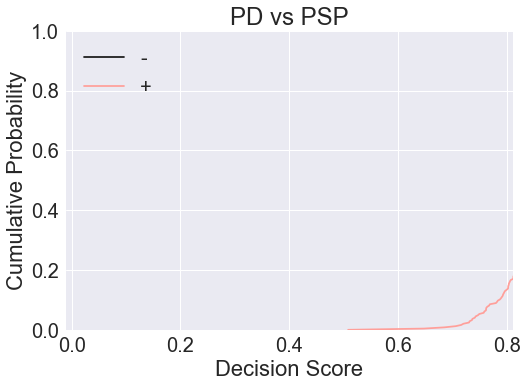

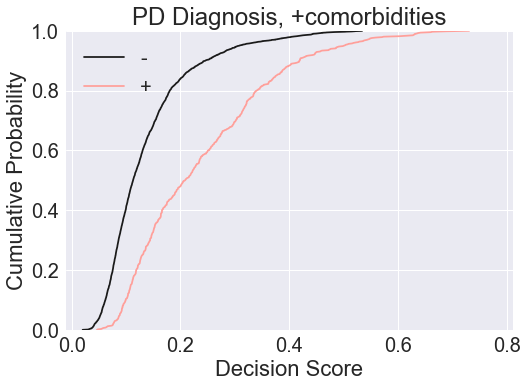

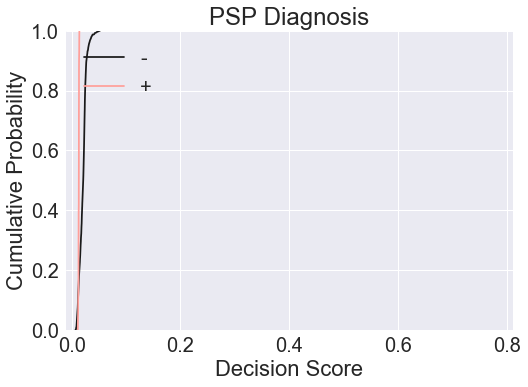

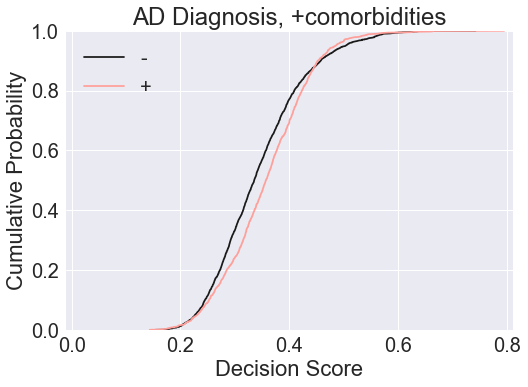

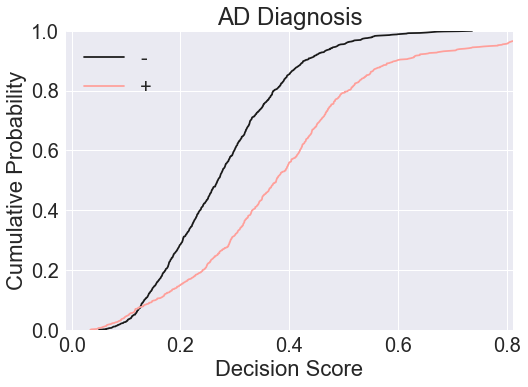

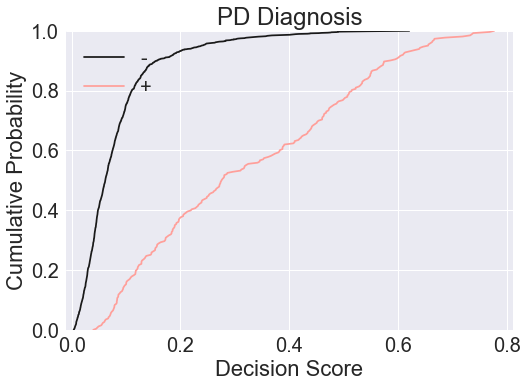

In [12]:
for key in keys:
    plt.figure()
    s.plot_cumul(p_pos[key]['Which Responses']['average'][:,None],ys[key],'Decision Score')
    plt.title(keys[key])
    plt.xlim(-0.01,0.81)
    s.save_fig()

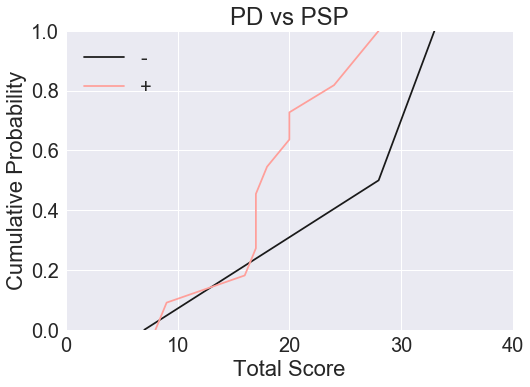

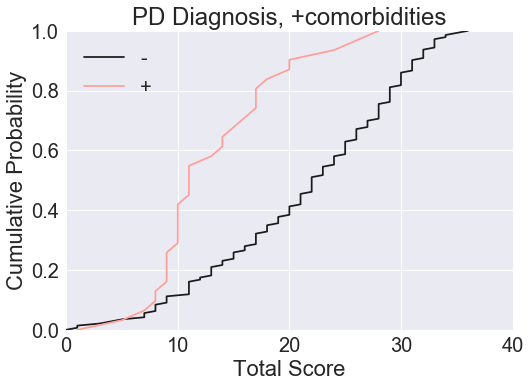

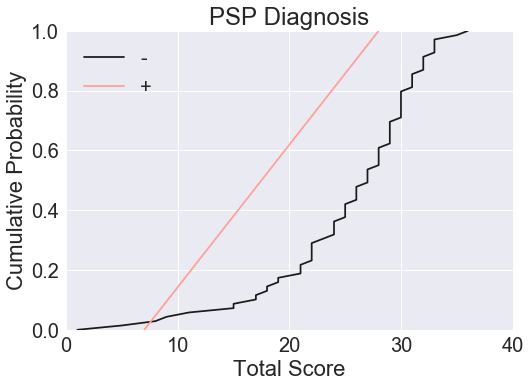

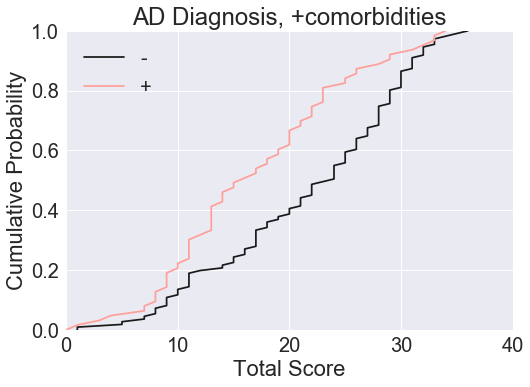

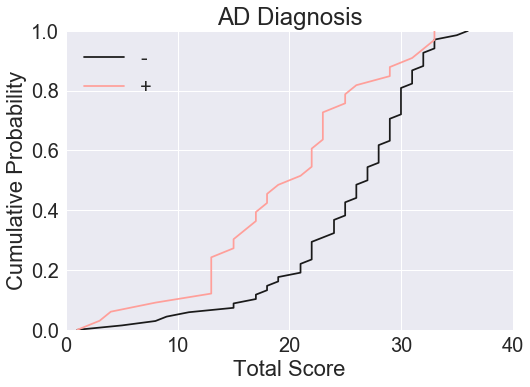

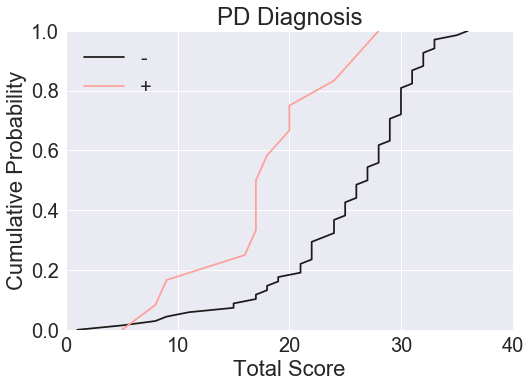

In [13]:
for key in keys:
    plt.figure()
    s.plot_cumul(X[key]['Total Score']['upsit_total_correct'],Y[key],'Total Score')
    plt.title(keys[key])
    plt.xlim(0,40)
    s.save_fig()

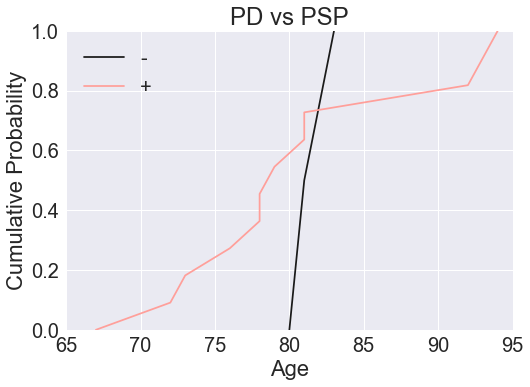

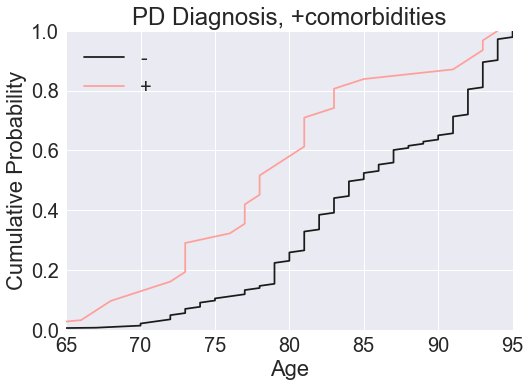

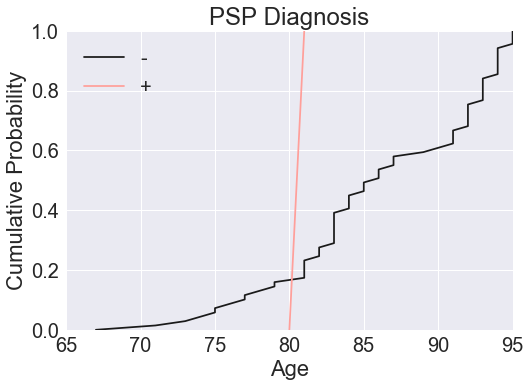

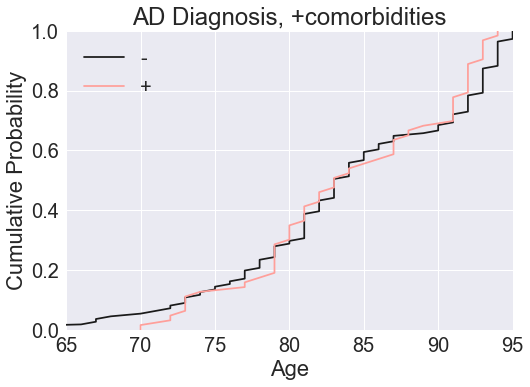

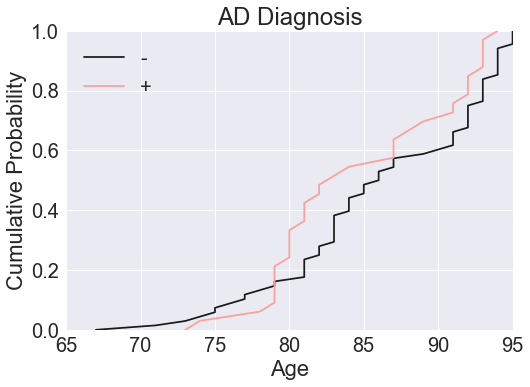

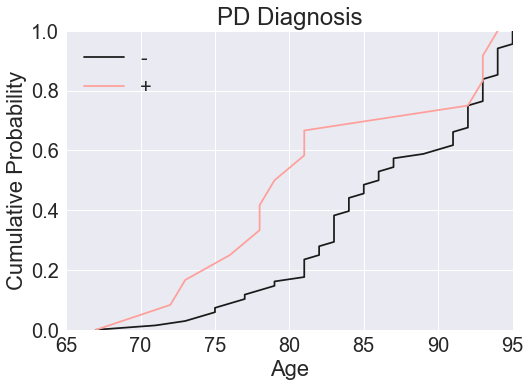

In [14]:
for key in keys:
    plt.figure()
    s.plot_cumul(X[key]['Total Score']['age'],Y[key],'Age')
    plt.title(keys[key])
    plt.xlim(65,95)
    s.save_fig()

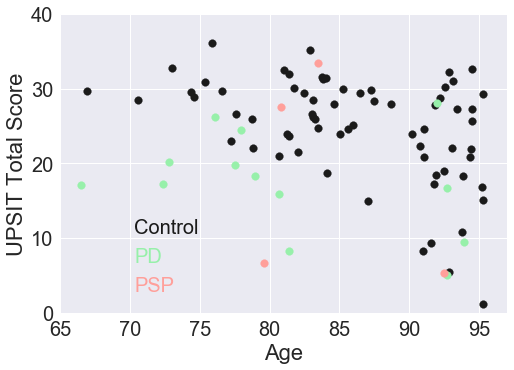

In [15]:
for color,label,subset in [('k','Control',(df['Clinpath Control']==1) & (df['Clinpath PSP']==0)),
                     ('g','PD',(df['Clinpath PD']==1) & (df['dementia']==0)),
                     ('r','PSP',(df['Clinpath PSP']==1) & (df['dementia']==0))]:
    z = clin[subset]
    n = z.shape[0]
    plt.scatter(z['age']+np.random.rand(n)-0.5,
                z['upsit_total_correct']+np.random.rand(n)-0.5,
                c=color,
                s=60,
                label=label)
plt.xlabel('Age')
plt.ylabel('UPSIT Total Score')
plt.xlim(65,97)
plt.ylim(0,40)
l = plt.legend(loc=3,markerscale=0)
for i,text in enumerate(l.get_texts()):
    text.set_color('kgr'[i])
s.save_fig()

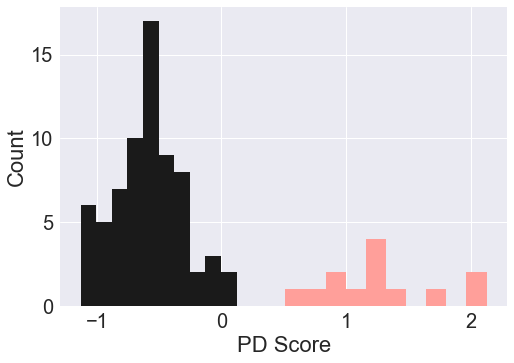

In [16]:
z = clin.join(df.loc[clin.index,:][['Clinpath Control','Clinpath PD','dementia']])
z = z[(z['dementia']==0) & ((z['Clinpath Control']==1) | (z['Clinpath PD']==1))]
pattern = [f for f in list(z) if re.match('upsit_[0-9]+[a-d]',f)]
lda = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#,n_components=2)
ft = lda.fit_transform(z[pattern],z['Clinpath PD'])
lda_shuff = {}
ft_shuff = {}
n_shuff = 1000
for i in range(n_shuff):
    lda_shuff[i] = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#,n_components=2)
    z_shuff = z.copy()
    z_shuff['Clinpath PD'] = np.random.rand(z.shape[0])<z['Clinpath PD'].mean()
    ft_shuff[i] = lda_shuff[i].fit_transform(z_shuff[pattern],z_shuff['Clinpath PD'])
sns.set(font_scale=2)
for i in [0,1]:
    index = np.where(z['Clinpath PD']==i)
    #plt.figure(1)
    #plt.scatter(ft[index,0],ft[index,1],color='kr'[i],s=50,label=['Control','PD'][i])
    plt.figure(2)
    plt.hist(ft[index,0].ravel(),bins=10,color='kr'[i])
#plt.figure(1)
#lgd = plt.legend(markerscale=0,fontsize=24)
#plt.xlabel('LDA Dimension 1')
#plt.ylabel('LDA Dimension 2')
#for i,text in enumerate(lgd.get_texts()):
#    text.set_color('kr'[i])
plt.figure(2)
plt.xlabel('PD Score')
plt.ylabel('Count')
s.save_fig()

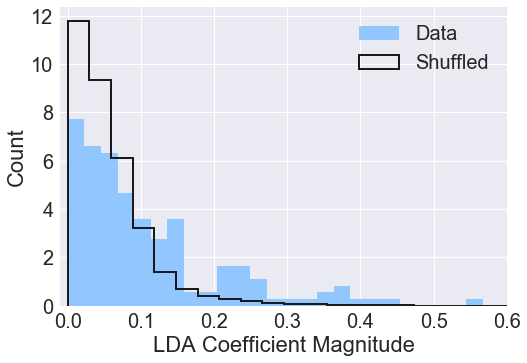

In [17]:
plt.hist(np.abs(lda.coef_.T),color='b',bins=25,normed=True,histtype='stepfilled',label='Data')
shuff_coefs = np.abs(np.ravel([lda_shuff[i].coef_.T for i in range(n_shuff)]))
plt.hist(shuff_coefs,bins=25,color='k',normed=True,histtype='step',linewidth=2,label='Shuffled');
plt.xlabel('LDA Coefficient Magnitude')
plt.ylabel('Count')
plt.xlim(-0.01,0.6)
plt.legend()
s.save_fig()

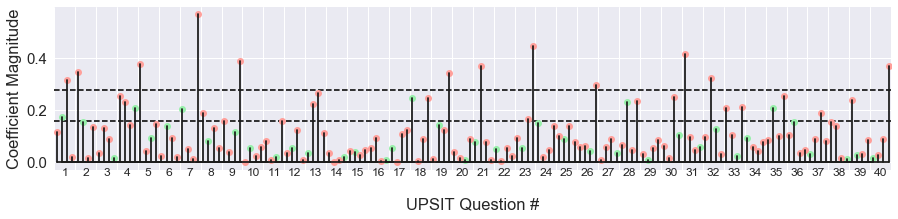

In [18]:
correct_answers = np.array(correct)-1+np.arange(0,160,4)
incorrect_answers = np.array(list(set(range(160)).difference(correct_answers)))
sns.set(font_scale=1.5)
plt.figure(figsize=(15,3))
plt.stem(1.125+correct_answers/4,np.abs(lda.coef_.T[correct_answers]),linefmt='k-', markerfmt='go', basefmt='k-')
plt.stem(1.125+incorrect_answers/4,np.abs(lda.coef_.T[incorrect_answers]),linefmt='k-', markerfmt='ro', basefmt='k-')
plt.hlines(np.percentile(shuff_coefs,95),1,41,linestyle='--')
plt.hlines(np.percentile(shuff_coefs,99),1,41,linestyle='--')
plt.xticks(range(1,41,1),[""]*40,rotation=0,fontsize=14);
plt.xlim(1,41)
for i in range(1,41):
    plt.text(i+0.5,-0.05,i,fontsize=12,ha='center')
plt.xlabel('UPSIT Question #',labelpad=20)
plt.ylabel('Coefficient Magnitude')
s.save_fig()

In [19]:
test_key = pd.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey').drop('Unnamed: 4',1)

In [20]:
pd = clin[((df['Clinpath PD']==1) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0))]
no_pd = clin[((df['Clinpath PD']==0) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0))]

In [21]:
coefs = sorted(np.abs(lda.coef_.T).ravel(),reverse=True)
ps = [(shuff_coefs>coef).mean() for coef in coefs]
ps = [ps[i]*80/(i+1) for i in range(len(coefs))]
#print(ps)
print("Q) Response (Correct), PD vs CTRL")
for i,coef in enumerate(lda.coef_.T):
    question = int(i/4)+1
    letter = 'abcd'[i%4]
    if coef>np.percentile(shuff_coefs,99):
        correct = test_key['Correct answer'].loc['smell %d' % question]
        row = 'smell %d' % question
        pd_f = pd['upsit_%d%s' % (question,letter)].mean()
        no_pd_f = no_pd['upsit_%d%s' % (question,letter)].mean()
        print('%d) %s (%s),& %.2f & %.2f' % (question,test_key.loc[row,correct],test_key.loc[row,(i%4)+1],pd_f,no_pd_f))

Q) Response (Correct), PD vs CTRL
1) pizza (peanuts),& 0.22 & 0.07
2) bubble gum ( dill pickle),& 0.22 & 0.06
5) motor oil (grass),& 0.43 & 0.14
7) banana (motor oil),& 0.48 & 0.07
9) leather  (apple),& 0.26 & 0.04
19) chocolate (black pepper),& 0.35 & 0.04
21) lilac (chili),& 0.39 & 0.06
23) peach (pizza),& 0.13 & 0.01
26) pineapple (onion),& 0.30 & 0.06
31) paint thinner (watermelon),& 0.22 & 0.03
32) grass (gingerbread),& 0.39 & 0.17
40) peanut (root beer),& 0.22 & 0.06


In [22]:
#p_pos,ys = s.make_py({'pd_only vs ctrl':'PD Diagnosis'},uses,X,Y,clfs,ignore=list(young))
#s.plot_rocs({'pd_only vs ctrl':'PD Diagnosis'},uses,p_pos,Y,ys,no_plot=True)

In [23]:
keys2 = {'pd_only vs ctrl':'PD Diagnosis'}
print("Women Only")
p_pos,ys = s.make_py(keys2,uses,X,Y,clfs,ignore=list(men))
s.plot_rocs(keys2,uses,p_pos,Y,ys,no_plot=True)
print("Men Only")
p_pos,ys = s.make_py(keys2,uses,X,Y,clfs,ignore=list(women))
s.plot_rocs(keys2,uses,p_pos,Y,ys,no_plot=True)
print("Young Only")
p_pos,ys = s.make_py(keys2,uses,X,Y,clfs,ignore=list(old))
s.plot_rocs(keys2,uses,p_pos,Y,ys,no_plot=True)
print("Old Only")
p_pos,ys = s.make_py(keys2,uses,X,Y,clfs,ignore=list(young))
s.plot_rocs(keys2,uses,p_pos,Y,ys,no_plot=True)

Women Only
	No UPSIT = 0.509 +/- 0.087
	Total Score = 0.762 +/- 0.085
	Which Correct = 0.816 +/- 0.071
	Which Order = 0.653 +/- 0.085
	Which Responses = 0.889 +/- 0.058
	Total Score vs No UPSIT: p=0.0008
	Which Correct vs No UPSIT: p=0.0000
	Which Correct vs Total Score: p=0.1208
	Which Order vs No UPSIT: p=0.0235
	Which Order vs Total Score: p=0.0504
	Which Order vs Which Correct: p=0.0093
	Which Responses vs No UPSIT: p=0.0000
	Which Responses vs Total Score: p=0.0197
	Which Responses vs Which Correct: p=0.0649
	Which Responses vs Which Order: p=0.0003
Men Only
	No UPSIT = 0.515 +/- 0.095
	Total Score = 0.765 +/- 0.083
	Which Correct = 0.848 +/- 0.067
	Which Order = 0.685 +/- 0.085
	Which Responses = 0.893 +/- 0.054
	Total Score vs No UPSIT: p=0.0012
	Which Correct vs No UPSIT: p=0.0000
	Which Correct vs Total Score: p=0.0680
	Which Order vs No UPSIT: p=0.0151
	Which Order vs Total Score: p=0.0852
	Which Order vs Which Correct: p=0.0086
	Which Responses vs No UPSIT: p=0.0000
	Which R

/Users/rgerkin/Dropbox/science/upsit/scratch.py:380: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)


	No UPSIT = 0.602 +/- nan
	Total Score = 0.754 +/- 0.073
	Which Correct = 0.907 +/- 0.049
	Which Order = 0.753 +/- 0.077
	Which Responses = 0.913 +/- 0.044
	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=0.0035
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=0.2467
	Which Order vs Which Correct: p=0.0045
	Which Responses vs No UPSIT: p=nan
	Which Responses vs Total Score: p=0.0021
	Which Responses vs Which Correct: p=0.2228
	Which Responses vs Which Order: p=0.0028
Old Only


/Users/rgerkin/Dropbox/science/upsit/scratch.py:380: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(var)


	No UPSIT = 0.623 +/- nan
	Total Score = 0.686 +/- 0.093
	Which Correct = 0.779 +/- 0.078
	Which Order = 0.603 +/- 0.088
	Which Responses = 0.849 +/- 0.063
	Total Score vs No UPSIT: p=nan
	Which Correct vs No UPSIT: p=nan
	Which Correct vs Total Score: p=0.0698
	Which Order vs No UPSIT: p=nan
	Which Order vs Total Score: p=0.0906
	Which Order vs Which Correct: p=0.0087
	Which Responses vs No UPSIT: p=nan
	Which Responses vs Total Score: p=0.0100
	Which Responses vs Which Correct: p=0.0797
	Which Responses vs Which Order: p=0.0003


({'pd_only vs ctrl': [0.62344240237813897,
   0.68624309872471445,
   0.77913093703678737,
   0.60342412945696178,
   0.84941207672143004]},
 {'pd_only vs ctrl': [nan,
   0.093332614253442497,
   0.077647149160527229,
   0.088410017293468077,
   0.062584980035168714]})